Daniel's project concerns the neural mechanisms that give agents the capacity to infer whether two objects have collided given they positions. 
One approach uses the vector dot product to assess similarity of two points, but in Euclidean space this requires normalizing the vectors.
In this notebook I explore how this could be done with HRRs.

### Holographic Reduced Representation (HRR)

HRR is a vector symbolic algebra used to specify theories of cognition such that they can be implemented in neural networks. In general, VSAs specify how to represent concepts as high-dimensional vectors, as well a set of semantically meaningful operations over those vectors. HRR is distinguished from most VSAs for its support of embedding continuous-valued data, via fractional binding or fractional power encoding. This is defined by mapping $\phi$:

$\phi(\lambda^{-1}x) = \mathcal{F}^{-1}{e^{i\Theta \lambda^{-1}x}}$

Where $x$ is the data in the domain with $k$ samples and $m$ features, $\lambda$ is a diagonal matrix whose elements specify the amount of pre-scaling to apply across features, $\Theta$ is a $d \times m$ matrix of randomly-sampled frequencies, and $\mathcal{F^{-1}}$  denotes the inverse Fourier transform. $\phi(x)$ maps data with dimensionality $m$ to a new vector space of dimensionality $d$. We construct $\Theta$ to have columns with conjugate symmetry. This ensures stable oscillations in the Fourier domain, and equivalently, stable magnitude in the spatial domain. The dimensionality $d$ is a free parameter, but is typically high. I use 4096 in this notebook. 

As this mapping is continuous, $\phi(x)$ is considered a Reproducing Kernel Hilbert Space (RKHS). As such, the dot product between vectors $\phi(x)\cdot\phi(x')$ induces a kernel in the domain. The shape of the kernel depends on the power spectral density function from which the frequencies in $\Theta$ were sampled. 

In [274]:
import matplotlib.pyplot as plt
import numpy as np

In [275]:
# you could have different kernels for different axis vectors
def make_unitary_matrix_fourier( ssp_dim, domain_dim, eps=1e-3, rng = np.random, kernel = 'triangle'):
    if kernel == 'sinc':
        a = rng.rand( (ssp_dim - 1)//2, domain_dim )
        sign = rng.choice((-1, +1), size=np.shape(a) )
        phi = sign * np.pi * (eps + a * (1 - 2 * eps))
    
    elif kernel == 'tophat':
        '''
        This doesn't work.
        '''
        fs = np.linspace( -100, 100, 1000000 )
        ps = np.abs(np.sinc(fs))
        ps /= ps.sum()
        phi = rng.choice( fs, p = ps, size = int((ssp_dim - 1)//2*domain_dim) ).reshape((ssp_dim - 1)//2, domain_dim)
        
    elif kernel == 'triangle':
        fs = np.linspace( -100, 100, 1000000 )
        ps = np.abs(np.sinc(fs))**2
        ps /= ps.sum()
        phi = rng.choice( fs, p = ps, size = int((ssp_dim - 1)//2*domain_dim) ).reshape((ssp_dim - 1)//2, domain_dim)

    fv = np.zeros( (ssp_dim,domain_dim), dtype='complex64')
    fv[0,:] = 1

    fv[1:(ssp_dim + 1) // 2,:] = phi
    fv[-1:ssp_dim // 2:-1,:] = -fv[1:(ssp_dim + 1) // 2,:]
    
    if ssp_dim % 2 == 0:
        fv[ssp_dim // 2,:] = 1

    return fv

class SSPEncoder:
    def __init__(self, phase_matrix, length_scale):
        '''
        Represents a domain using spatial semantic pointers.

        Parameters:
        -----------

        phase_matrix : cp.ndarray
            A ssp_dim x domain_dim ndarray representing the frequency 
            components of the SSP representation.

        length_scale : float or cp.ndarray
            Scales values before encoding.
        '''
        self.phase_matrix = phase_matrix
        self.domain_dim = self.phase_matrix.shape[1]
        self.ssp_dim = self.phase_matrix.shape[0]
        self.update_lengthscale(length_scale)

    def update_lengthscale(self, scale):
        '''
        Changes the lengthscale being used in the encoding.
        '''
        if not isinstance(scale, np.ndarray) or scale.size == 1:
            self.length_scale = scale * np.ones((self.domain_dim,))
        else:
            assert scale.size == self.domain_dim
            self.length_scale = scale
        assert self.length_scale.size == self.domain_dim
    
    def encode(self,x):
        '''
        Transforms input data into an SSP representation.

        Parameters:
        -----------
        x : cp.ndarray
            A (num_samples, domain_dim) array representing data to be encoded.

        Returns:
        --------
        data : cp.ndarray
            A (num_samples, ssp_dim) array of the ssp representation of the data
            
        '''
        
        x = np.atleast_2d(x)
        ls_mat = np.atleast_2d(np.diag(1/self.length_scale.flatten()))
        
        assert ls_mat.shape == (self.domain_dim, self.domain_dim), f'Expected Len Scale mat with dimensions {(self.domain_dim, self.domain_dim)}, got {ls_mat.shape}'
        scaled_x = x @ ls_mat
        data = np.fft.ifft( np.exp( 1.j * self.phase_matrix @ scaled_x.T), axis=0 ).real
        
        return data.T   
    
def RandomSSPSpace(domain_dim, ssp_dim, length_scale = None, 
                   rng = np.random.default_rng(), 
                   kernel = 'tophat'):
    
    phase_matrix = make_unitary_matrix_fourier(ssp_dim,domain_dim, kernel = kernel )

    length_scale = np.array( length_scale )
    return SSPEncoder(phase_matrix, length_scale=length_scale)

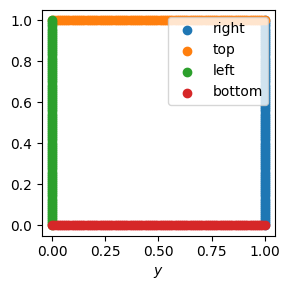

In [276]:
n_pts = 100

walls = {}
walls['right'] = np.vstack( [np.ones((n_pts)), np.linspace(0.,1.,n_pts) ] ).T
walls['top'] = np.vstack( [np.linspace(0.,1.,n_pts),np.ones((n_pts)) ] ).T
walls['left'] = np.vstack( [np.zeros((n_pts)), np.linspace(0.,1.,n_pts) ] ).T
walls['bottom'] = np.vstack( [np.linspace(0.,1.,n_pts),np.zeros((n_pts)) ] ).T

fig,ax = plt.subplots(1,1,figsize=(3.,3.))
for wall, data in walls.items():
    ax.scatter(data[:,0],data[:,1],label=wall)
ax.set_xlim(-0.05,1.05)
ax.set_xlabel(r'$x$')
ax.set_xlabel(r'$y$')
ax.set_ylim(-0.05,1.05)
ax.legend(loc='upper right')
fig.tight_layout()
plt.show()

### Bundling

$\phi_{WALL}(x) = \frac{1}{K_{WALL}}\sum_k \phi(x_k)$

In [277]:
domain_dim = 2
# triangular kernel would be really helpful here; 
# it would provide a straightforward mapping to the similarity needed to detect a collision
# also sinc kernels cannot detect collisions less than 0.2
# ... could use to estimate the length scale of the representation?

encoder = RandomSSPSpace( domain_dim = domain_dim, ssp_dim = 4096, length_scale = 0.05, kernel = 'triangle' )
# next, we will project the data for the walls into SSP Space

wall_phis = {}

for wall, data_xs in walls.items():
    data_phis = encoder.encode( data_xs )

    wall_phi = data_phis.sum( axis = 0 )
    wall_phi /= np.linalg.norm( wall_phi )
    
    wall_phis[wall] = wall_phi

In [278]:
# generate query points
domain_bounds = np.tile(np.array([[-0.05],[1.05]]),domain_dim).T

n_query_pts = 100
meshes = np.meshgrid(*[np.linspace(b[0],b[1],n_query_pts) for b in domain_bounds ])
query_xs = np.vstack( [m.flatten() for m in meshes] ).T
# fig,ax = plt.subplots(1,1)
# ax.scatter(query_xs[:,0],query_xs[:,1],s=1)
# plt.show()

# map to sspspace
query_phis = encoder.encode(query_xs)

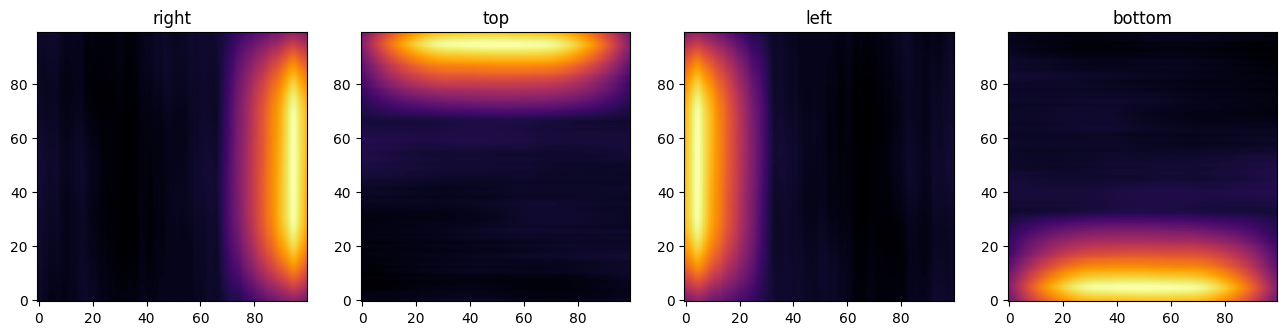

In [279]:
fig,axs = plt.subplots(1,4,figsize=(16.,4.))

for ax,(wall,phi) in zip(axs,wall_phis.items()):
    sims = np.dot(query_phis,phi)
    ax.imshow(sims.reshape(n_query_pts,n_query_pts),origin='lower',cmap = 'inferno')
    ax.set_title(wall)
plt.show()

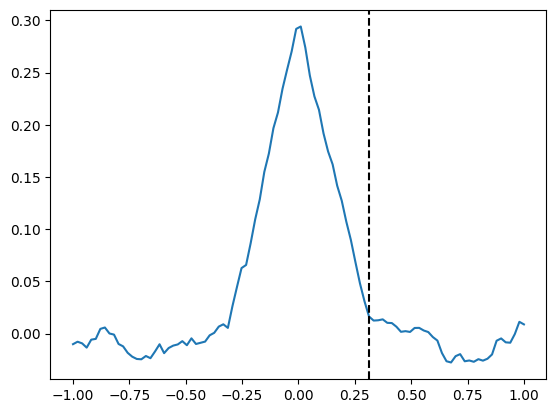

In [280]:
# Did I create a triangular kernel?

eval_xs = np.vstack( [np.linspace(-1.,1.,n_pts),np.zeros((n_pts)) ] ).T
eval_phis = encoder.encode(eval_xs)
sims = np.dot( eval_phis,wall_phis['left'] )
fig,ax = plt.subplots(1,1)
ax.plot(eval_xs[:,0],sims)
ax.axvline(2*np.pi*encoder.length_scale.mean(),color='k',linestyle='--')
plt.show()

This looks pretty triangular, with similarity approaching to zero as $x \to 2 \pi\lambda$. We could expect to improve the approximation of the kernel by increasing the dimensionality of the hypervector, and as a consequence, the density with which we sampled of the power spectrum distribution.

### Neural network implementation

This representation allows us to build a neural network that can perform collision detection.
If we select a neuron's preferred direction to be some $\phi_{wall}$, and provide input as $\phi(x)$, the neuron's activity will be some linear function of the proximity of $x$ to that wall. 